In [1]:
%matplotlib inline
from skimage import io
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
from glob import glob
from skimage.filters import sobel
import numpy as np
from itertools import product
import skimage.morphology as mp
from skimage import measure
from skimage.measure import find_contours as fc

In [2]:
def collage(data, n=7, m=3, width=12, imparams={}):
    sh = data[0].shape
    ratio = sh[0]/sh[1] * n/m
    fig, axes = plt.subplots(n, m,
                             gridspec_kw={"wspace": 0, "hspace": 0})
    fig.set_size_inches(width, width*ratio)
    axes = axes.flatten()
    for i, img in enumerate(data):
        axes[i].axis("off")
        axes[i].imshow(img, aspect='auto', **imparams)
    plt.show()

In [3]:
planes_orig = [io.imread(fn) for fn in sorted(glob("data/samolot??.jpg"))]
planes_bw = [rgb2gray(p) for p in planes_orig]

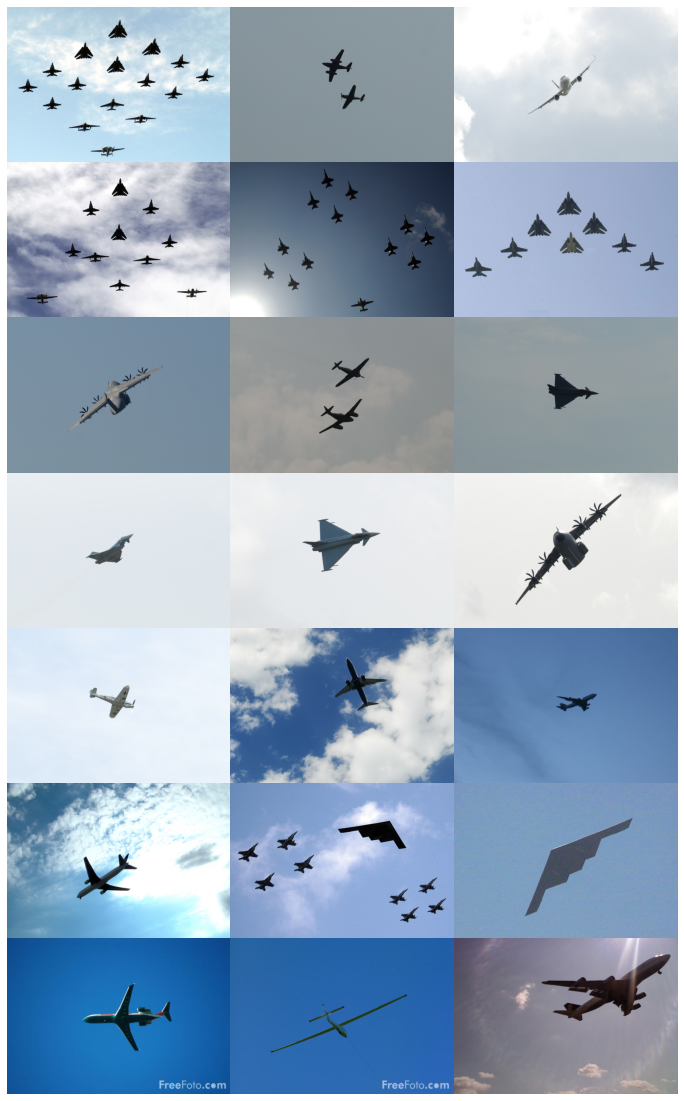

In [4]:
collage(planes_orig)

In [5]:
from fractions import Fraction
sh = planes_orig[0].shape
print(Fraction(sh[0], sh[1]))
ar = sh[0]/ sh[1]
ar

5/7


0.7142857142857143

In [6]:
def bbox(c):
    diag = *np.min(c, 0), *np.max(c, 0)
    return list(product(diag[::2], diag[1::2]))
def in_bbox(p, diag, sl=0):
    return diag[0][0]-sl < p[0] < diag[1][0]+sl and \
            diag[0][1]-sl < p[1] < diag[1][1]+sl
def intersect(bb1, bb2, slack=0):
    d1 = [bb1[0], bb1[3]]
    d2 = [bb2[0], bb2[3]]
    return any(in_bbox(p, d2, slack) for p in bb1) or \
            any(in_bbox(p, d1, slack) for p in bb2)


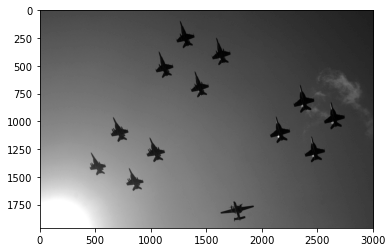

In [54]:
planes = planes_bw.copy()
pp1 = planes[4]
plt.imshow(pp1, cmap='gray')

0.04900459234659664


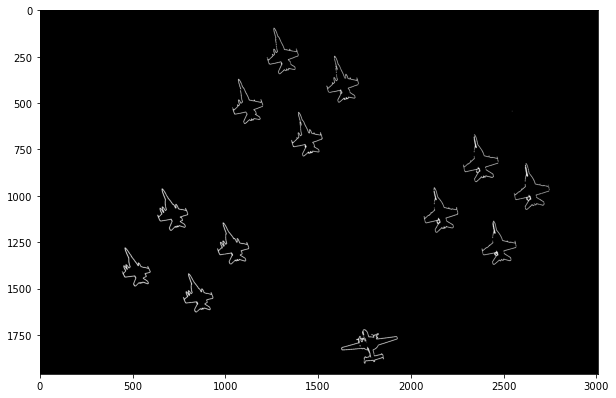

In [76]:
pp = pp1.copy()
pp = sobel(pp)
t = np.percentile(pp, 99.25)
print(t)
pp = (pp > t)*1.0
w = 10
pp = mp.erosion(pp)
pp = mp.dilation(pp)
plt.figure(figsize=(w, w/ar))
plt.imshow(pp, cmap='gray')



In [140]:
def bboxwh(bb):
    return bb[3][0]-bb[0][0], bb[3][1]-bb[0][1]

a = cs[0]
a = bbox(a)
print(a, [round(x, 1) for x in bboxwh(a)])

[(94.8, 1258.8), (94.8, 1366.2), (222.2, 1258.8), (222.2, 1366.2)] [127.4, 107.4]


0.04900459234659664


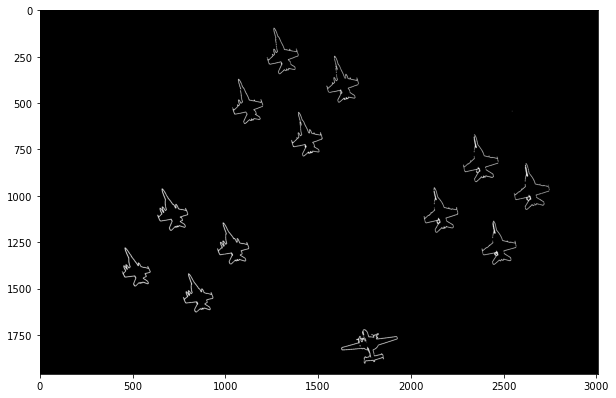

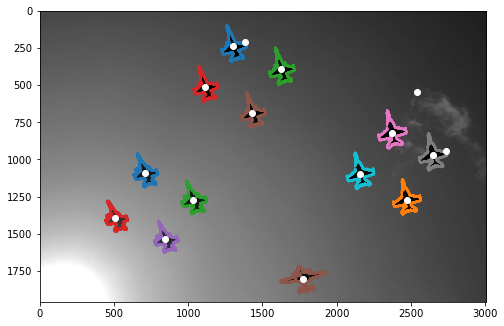

In [143]:
pp = pp1.copy()
pp = sobel(pp)
t = np.percentile(pp, 99.25)
print(t)
pp = (pp > t)*1.0
w = 10
pp = mp.erosion(pp)
pp = mp.dilation(pp)
plt.figure(figsize=(w, w/ar))
plt.imshow(pp, cmap='gray')

cs = fc(pp, level=0.8)

cs2 = [cs[0]]
bboxes = [bbox(cs[0])]
#slack = 20
for c in cs[1:]:
    bb = bbox(c)
    for i, (c1, bb1) in enumerate(zip(cs2, bboxes)):
        slack = np.mean([*bboxwh(bb), *bboxwh(bb1)])*0.1
        if intersect(bb, bb1, slack):
            c1 = cs2[i] = np.append(c1, c, 0)
            bboxes[i] = bbox(cs2[i])
            break
    else:
        cs2.append(c)
        bboxes.append(bbox(c))
w = 8
plt.figure(figsize=(w, w/ar))
plt.imshow(pp1, cmap='gray')
for c in cs2:
    ctr = np.mean(c, 0)
    plt.scatter(c[:,1], c[:,0], [1]*len(c))
    plt.scatter([ctr[1]], [ctr[0]], c='w')


In [214]:
def plot_cont(bw_pic, col_pic=None):
    pp = bw_pic.copy()
    imw = pp.shape[0]
    
    pp = sobel(pp)
    t = np.percentile(pp, 99.25)
    print(t)
    pp = (pp > t)*1.0

    cs = fc(pp, level=0.8)

    cs2 = [cs[0]]
    bboxes = [bbox(cs[0])]
    
    slack = pp.shape[0]*0.02
    for c in cs[1:]:
        bb = bbox(c)
        wh = bboxwh(bb)
        for i, (c1, bb1) in enumerate(zip(cs2, bboxes)):
            #slack = max([*wh, *bboxwh(bb1)])*0.2
            if intersect(bb, bb1, slack):
                c1 = cs2[i] = np.append(c1, c, 0)
                bboxes[i] = bbox(cs2[i])
                break
        else:
            cs2.append(c)
            bboxes.append(bbox(c))
    w = 8
    plt.figure(figsize=(w, w/ar))
    plt.imshow(bw_pic, cmap='gray') if col_pic is None else plt.imshow(col_pic)
    for c in cs2:
        ctr = np.mean(c, 0)
        plt.scatter(c[:,1], c[:,0], [1]*len(c))
        plt.scatter([ctr[1]], [ctr[0]], c='w')

0.2654414067520748


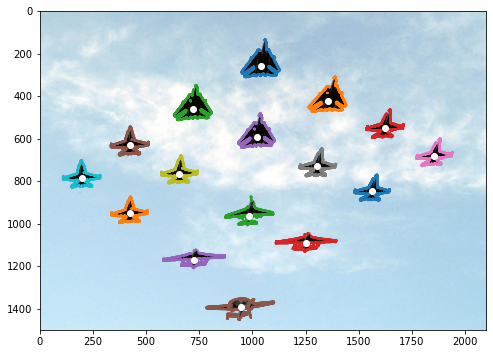

In [215]:
pi = 0
plot_cont(planes_bw[pi], planes_orig[pi])

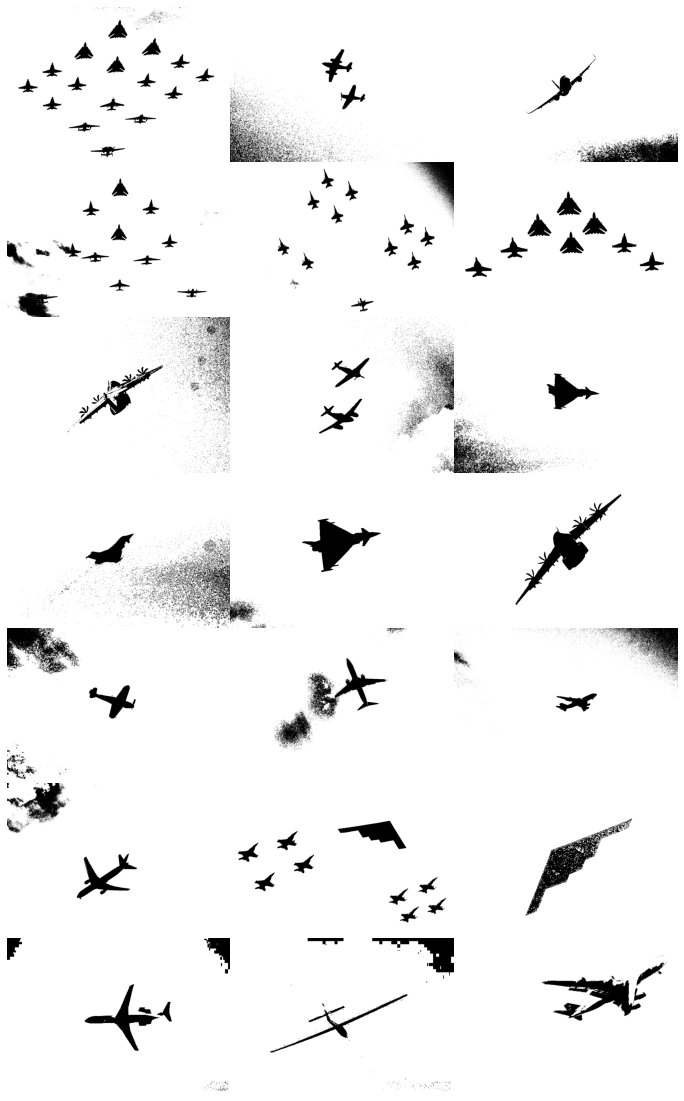

In [73]:
planes = planes_bw.copy()
for i in range(len(planes)):
    p = planes[i]
    th = np.percentile(p, 5)
    p = (p>th)*1.0
    planes[i] = p
collage(planes, imparams={"cmap": "gray"})

In [12]:
for i in range(len(planes)):
    p = planes[i]
    planes[i] = sobel(p)

In [13]:
print(planes[0].dtype)

float64


In [14]:
from skimage.draw import polygon

In [15]:
plbak = planes_orig.copy()

0
1386


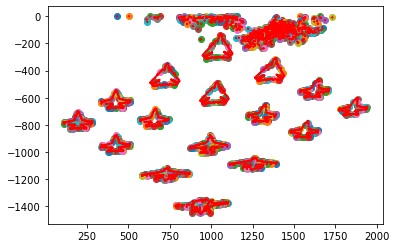

In [16]:
planes2 = [np.uint8(255*p) for p in planes]
for i in range(len(planes2)):
    p = planes2[i]
    mn = np.mean(p)
    p = (p > 40)*255
    p = mp.erosion(p)
    p = mp.dilation(p)
    cs = measure.find_contours(p, 0.2)
    print(i)
    #rr, cc = polygon(cs[:, 1], cs[:, 0])
    fig, ax = plt.subplots()
    print(len(cs))
    for c in cs:
        ax.plot(c[:,1], -c[:,0], 'r')
        m = np.mean(c, 0)
        ax.scatter(m[1], -m[0])
        #plbak[i][polygon(c[:,0], c[:,1])] = [1, 0, 0]
    #p[rr][cc] = 1
    break
        
    

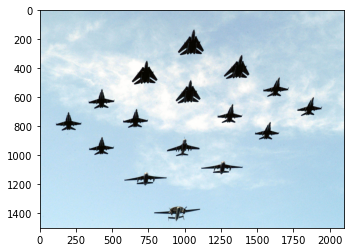

In [17]:

plt.imshow(plbak[0])

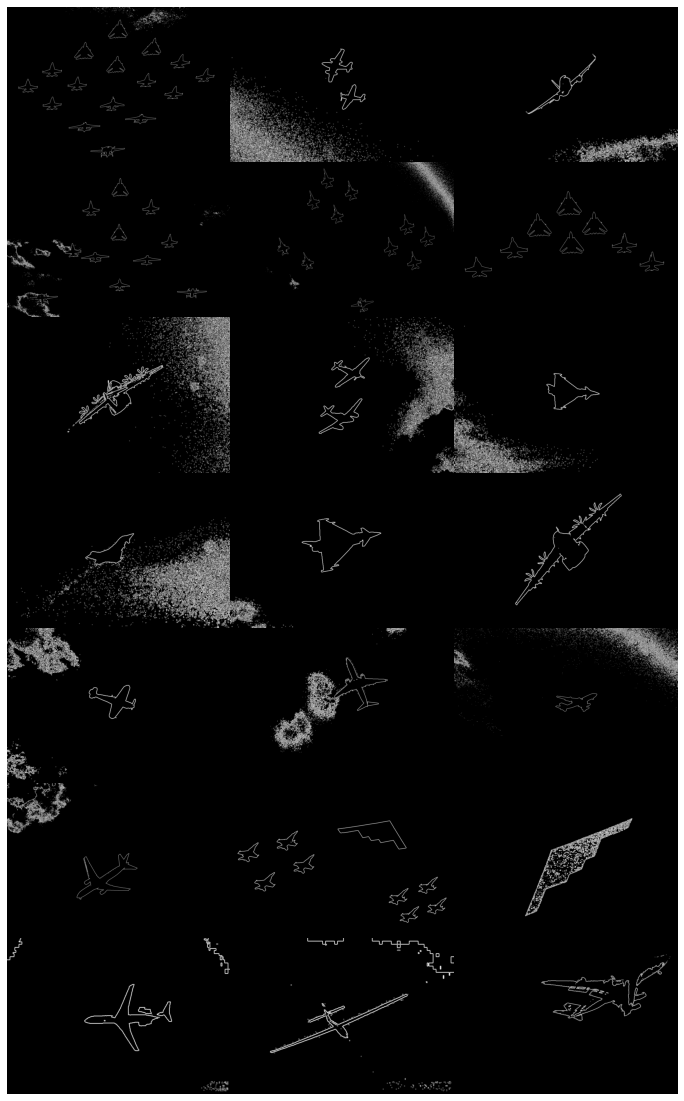

In [18]:
collage(planes2, imparams={"cmap": "gray"})